In [17]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras.backend as K


In [18]:
parameter_data = pd.read_csv('../02_machine_learning/parameter_data_lead_time_also_FZ.csv')
parameter_data.drop(columns=['airport_id'], inplace=True)
parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [19]:
# Train test split
X_train, X_test = train_test_split(parameter_data, test_size = 0.2, random_state=9)

### Downsampling the occurrences of FALSE for contain_FZ

In [20]:
downsampling_percentage = 0.01

fz_majority = X_train[X_train['contain_FZ'] == False]
fz_minority = X_train[X_train['contain_FZ'] == True]

print(f'Size of minority: {fz_majority.shape}')
print(f'Size of minority: {fz_minority.shape}')

majority_size = int(len(fz_majority) * downsampling_percentage)

#Downsample the majority class to match the minority class
downsampled_majority = resample(fz_majority, replace=False, n_samples=majority_size, random_state=42)
print(f'Size of downsampled majority: {downsampled_majority.shape}')

#Combine the downsampled majority class with the original minority class
downsampled_X_train = pd.concat([downsampled_majority, fz_minority])

Size of minority: (440007, 127)
Size of minority: (4243, 127)
Size of downsampled majority: (4400, 127)


In [21]:
fz_majority_test = X_test[X_test['contain_FZ'] == False]
fz_minority_test = X_test[X_test['contain_FZ'] == True]
print(f'Size of majority in test dataset: {fz_majority_test.shape}')
print(f'Size of minority in test dataset: {fz_minority_test.shape}')

Size of majority in test dataset: (109993, 127)
Size of minority in test dataset: (1070, 127)


In [15]:
X_train_downsampled = downsampled_X_train.drop(['contain_FZ'], axis=1)
y_train = downsampled_X_train['contain_FZ']
y_test = X_test['contain_FZ']
X_test = X_test.drop(['contain_FZ'], axis=1)

## F1-score 

In [22]:
def f1_score_calc(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Standardize features

In [24]:
data_params = ['air_temperature_0m', 'air_temperature_2m', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'fog_area_fraction', 'surface_air_pressure', 
               'air_pressure_at_sea_level', 'precipitation_amount_calculated',
              'air_temperature_pl_850', 'x_wind_pl_850', 'y_wind_pl_850', 'air_temperature_pl_925', 'x_wind_pl_925', 'y_wind_pl_925',
              'liquid_water_content_of_surface_snow']

In [25]:
scaler = StandardScaler()

X_train_downsampled[data_params] = scaler.fit_transform(X_train_downsampled[data_params])
X_test[data_params] = scaler.transform(X_test[data_params])

## Embedding layer for airport id

In [26]:
num_airports = len(parameter_data['airport_id'].unique())
print(f'Number of airports: {num_airports}')
input_aid = Input(shape=(1,))
output_dim = 20

embedding_layer = Embedding(input_dim=num_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
flatten_airports = Flatten()(embedding_layer)

emb_cat = Reshape(target_shape=(output_dim,))(flatten_airports)

Number of airports: 54


## Model:ANN

In [27]:
l1_lambda = 0.002

#param_features_dim = Input(shape=(16,))

# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat])

dense_layer_1 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(concat)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dropout_1 = Dropout(0.2)(batch_norm_1)

dense_layer_2 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)

dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer_3)


#dense_layer_4 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(dense_layer_3)

#batch_norm_2 = BatchNormalization()(dense_layer_3)

#dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_2)
#batch_norm_3 = BatchNormalization()(dense_layer_3)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

# Output Layer
output_layer = Dense(units=1, activation='sigmoid')(batch_norm_3)
model = Model(inputs=[input_aid], outputs=output_layer)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_airport (Embeddi  (None, 1, 20)             1080      
 ng)                                                             
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 reshape (Reshape)           (None, 20)                0         
                                                                 
 concatenate (Concatenate)   (None, 20)                0         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                             

In [29]:
# Compile the model
ml_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=ml_optimizer, metrics=[f1_score_calc])

In [30]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
history = model.fit([X_train_downsampled['airport_id']], y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=1, callbacks=early_stopping)

Epoch 1/100


/home/tonjek/.local/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


217/217 [==============================] - 2s 2ms/step - loss: 3.3886 - f1_score_calc: 0.5494 - val_loss: 3.5312 - val_f1_score_calc: 0.0000e+00
Epoch 2/100
217/217 [==============================] - 0s 2ms/step - loss: 2.7012 - f1_score_calc: 0.5451 - val_loss: 2.7777 - val_f1_score_calc: 0.3244
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 2.1983 - f1_score_calc: 0.5340 - val_loss: 2.3050 - val_f1_score_calc: 0.5716
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 1.8280 - f1_score_calc: 0.5421 - val_loss: 1.9645 - val_f1_score_calc: 0.5535
Epoch 5/100
217/217 [==============================] - 0s 1ms/step - loss: 1.5330 - f1_score_calc: 0.5445 - val_loss: 1.7048 - val_f1_score_calc: 0.5492
Epoch 6/100
217/217 [==============================] - 0s 1ms/step - loss: 1.3096 - f1_score_calc: 0.5432 - val_loss: 1.5038 - val_f1_score_calc: 0.5332
Epoch 7/100
217/217 [==============================] - 0s 1ms/step - loss: 1.1521 - f1_sco

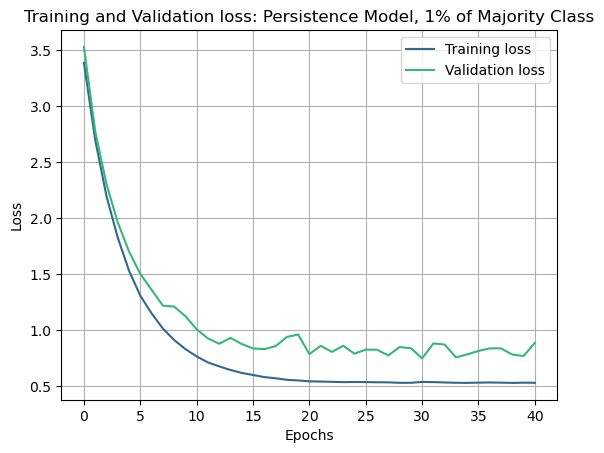

In [32]:
history = pd.DataFrame(history.history)
cmap_loss_val = sns.color_palette('viridis', 2)


plt.plot(history.loc[:, ['loss']], color=cmap_loss_val[0], label='Training loss')
plt.plot(history.loc[:, ['val_loss']], color=cmap_loss_val[1], label='Validation loss')
plt.title('Training and Validation loss: Persistence Model, 1% of Majority Class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(True)

plt.savefig('training_validation_loss.png')
plt.show()

## Prediction

In [33]:
# Make predictions
y_pred = model.predict([X_test['airport_id']])

3471/3471 [==============================] - 2s 611us/step


In [34]:
y_pred_val = (y_pred > 0.4)
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

       False       1.00      0.70      0.82    109993
        True       0.02      0.74      0.05      1070

    accuracy                           0.70    111063
   macro avg       0.51      0.72      0.43    111063
weighted avg       0.99      0.70      0.82    111063



In [35]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

In [36]:
conf_matrix

array([[77209, 32784],
       [  276,   794]])

In [37]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_val)

In [38]:
f1

0.04583237127684137

## ROC AUC

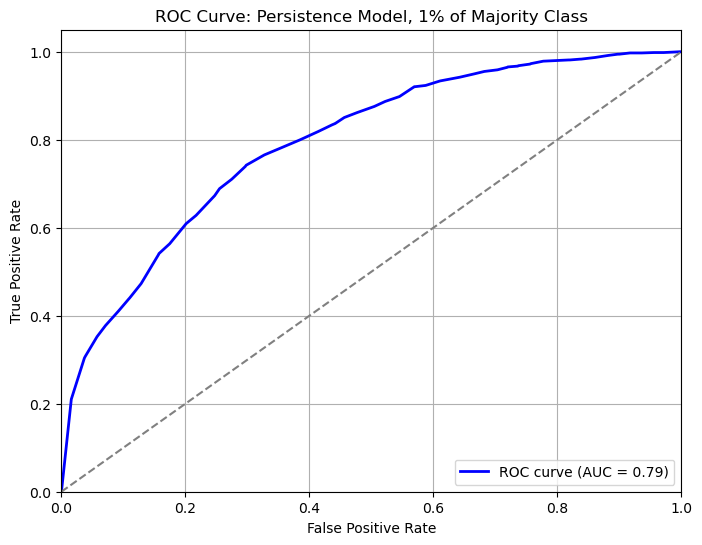

In [39]:

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Persistence Model, 1% of Majority Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('rocauc_persistence.png')
plt.show()

In [1]:
# Save y_pred as numpy
#np.save('y_pred_persistence.npy', y_pred)

# Save corresponding y_test
#np.save('y_test_persistence', y_test)

# Analyzation of data
The code from here and forward is for analyzation purposes. 

In [40]:
y_pred = y_pred.flatten()

In [41]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Time': X_test['time'], 'Metar': X_test['metar']})

In [42]:
comparison_df.to_csv('comparison.csv', index=False)

In [43]:
pd.set_option('display.max_colwidth', 3000)

In [44]:
comparison_df[comparison_df['Predicted'] > 0.95].head(50)

,Actual,Predicted,Time,Metar


In [45]:
comparison_df[comparison_df['Actual'] == True].head(50)

,Actual,Predicted,Time,Metar
177484,True,0.707845,2022-01-03 09:00:00,ENGM 030920Z 00000KT 0650 R19R/1000D R01R/1100N R19L/0650N R01L/0750N FZFG VV003 M03/M03 Q0987 TEMPO 0500 FZFG=
411876,True,0.533378,2023-03-13 22:00:00,ENRY 132150Z 33008KT 6000 -FZRA SCT004/// BKN008/// OVC029/// M00/M01 Q0969 REFZUP=
330844,True,0.809643,2023-11-18 14:00:00,ENNM 181350Z 07009KT 9999 OVC059/// M05/M06 Q1021 REFZRA=
125144,True,0.527121,2021-01-19 23:00:00,ENCN 192320Z 05010KT 9999 OVC006/// 00/M00 Q0996 REFZRA=
328576,True,0.809643,2023-03-08 02:00:00,ENNM 080220Z 10015KT 9999 -FZRA ////// M09/M14 Q0992=
19918,True,0.522082,2023-02-11 00:00:00,ENAN 102350Z 30027G38KT 1100 R14///// FZUP VV010 M03/M04 Q0995 RESN=
473629,True,0.543215,2023-11-23 03:00:00,ENSS 230320Z 16026KT 9999 BKN013/// OVC017/// M05/M07 Q0986 REFZDZ RMK WIND 0500FT 16024KT=
326922,True,0.809643,2022-12-25 22:00:00,ENNM 252150Z 10015KT 9999 BKN078 M01/M06 Q0999 REFZRA=
413141,True,0.533378,2023-11-02 03:00:00,ENRY 020320Z 04009KT 9999 -PL FEW005/// OVC010/// M01/M02 Q0997 REFZRA=
315121,True,0.344222,2022-11-09 02:00:00,ENNA 090150Z 21003KT 0250 R16/1600U R34/0900N FZFG VV003 M00/M01 Q1010 RMK WIND 1800FT 10007KT=


<AxesSubplot: >

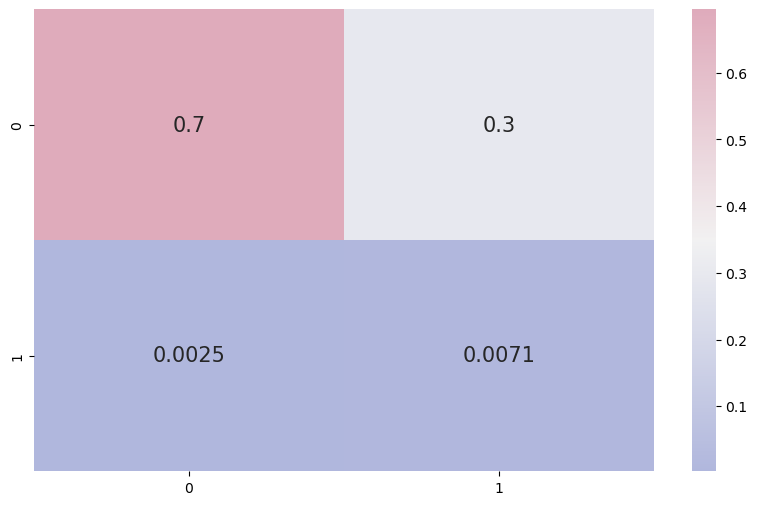

In [46]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

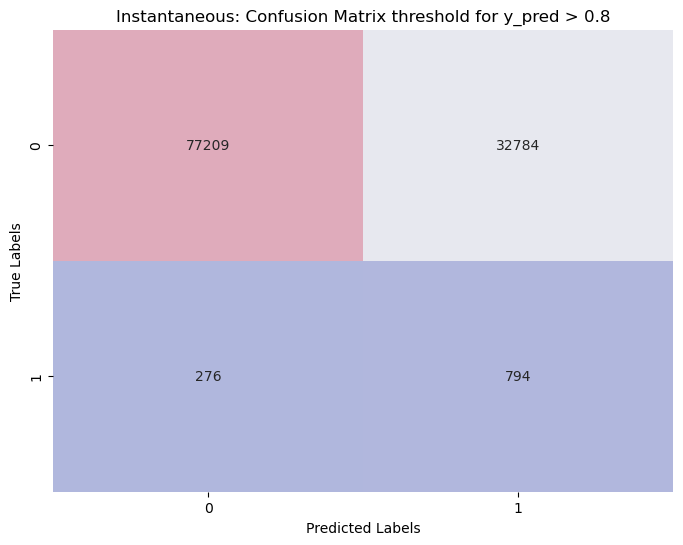

In [47]:
# Step 6: Evaluate the model with a confusion matri
conf_matrix = confusion_matrix(y_test, y_pred_val)

# Step 7: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap1, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Instantaneous: Confusion Matrix threshold for y_pred > 0.8')
plt.savefig('cmap_instantaneous_0.8.png')
plt.show()